In [10]:
#!/usr/bin/env python3

import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from pathlib import Path

# this makes all plots look nicer, and high dpi
# sn.set_theme(style="whitegrid", font_scale=1.0, rc={"figure.dpi": 200})
# set a nicer font
# plt.rcParams["font.family"] = "serif"
# To set some sane defaults
matplotlib.style.use("fivethirtyeight")
matplotlib.style.use("seaborn-dark-palette")
matplotlib.rcParams["font.family"] = "monospace"
matplotlib.rcParams["figure.dpi"] = 200
plt.rcParams["savefig.facecolor"] = "white"
# sn.set_context("talk")

KERNEL_NAMES = {
    0: "cuBLAS(C)",
    1: "SMEM Caching(C)",
    2: "cuBLAS(F)",
    3: "SMEM Chaching(F)"
}


def parse_file(file):
    """
    The data we want to parse has this format:

    Average elapsed time: (0.005661) s, performance: (24277.4) mflops. size: (4096).
    """
    with open(file, "r") as f:
        lines = [line.strip() for line in f.readlines()]

    data = {"size": [], "mflops": []}
    pattern = "Average elapsed time: \((.*?)\) s, performance: \((.*?)\) MFLOPS. size: \((.*?)\)."
    for line in lines:
        if r := re.match(pattern, line):
            # data["size"].append(int(r.group(3).split('x')[0]))
            # data["mflops"].append(float(r.group(2)))
            size = int(r.group(3).split('x')[0])
            data["size"].append(size)
            time = float(r.group(1))
            data['mflops'].append(calculate_mflops(size, time, r))
    return data

def calculate_mflops(size, time, r):
    return 2 * size **2 / 1000000 / float(r.group(1))


def plot(df: pd.DataFrame):
    """
    The dataframe has 3 columns: kernel, size, mflops

    We want to plot the mflops for each kernel, for each size as a single seaborn multi-line plot.
    """
    save_dir = Path.cwd()

    plt.figure(figsize=(18, 10))
    colors = sn.color_palette("husl", len(df["kernel"].unique()))
    sn.lineplot(data=df, x="size", y="mflops", hue="kernel", palette=colors)
    # also plot points, but without legend
    sn.scatterplot(data=df, x="size", y="mflops", hue="kernel", palette=colors, legend=False)

    # set ticks at actual sizes
    plt.xticks(df["size"].unique())
    # rotate xticks, and align them
    plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
    # add small lines at the xticks

    # display the kernel names right next to the corresponding line
    for i, kernel in enumerate(df["kernel"].unique()):
        # right align the text
        plt.text(
            df[df["kernel"] == i]["size"].iloc[-1],
            df[df["kernel"] == i]["mflops"].iloc[-1] + 300,
            f"{i}:{KERNEL_NAMES[i]}",
            color=colors[i],
            horizontalalignment="left",
            weight="medium",
        )

    # turn of the legend
    plt.gca().get_legend().remove()

    plt.title("Performance of different kernels")
    plt.xlabel("Matrix size (square, one side)")
    plt.ylabel("MFLOPs/s")
    plt.tight_layout()

    plt.savefig(save_dir / "sgemv_benchmark_results.png")





Generate dataframe for kenerl number, matrix size and mflops

In [11]:
results_dir = Path("benchmark_results/sgemv")
assert results_dir.is_dir()
data = []
for filename in results_dir.glob("*.txt"):
    # filenames have the format: <kernel_nr>_output.txt
    if not filename.stem.split("_")[0].isdigit() and "_output" not in filename.stem:
        continue
    results_dict = parse_file(filename)
    kernel_nr = int(filename.stem.split("_")[0])
    for size, mflops in zip(results_dict["size"], results_dict["mflops"]):
        data.append({"kernel": kernel_nr, "size": size, "mflops": mflops})
df = pd.DataFrame(data)
df



,kernel,size,mflops
0,0,64,25.761006
1,0,128,92.304225
2,0,256,375.564470
3,0,512,1230.723005
4,0,1024,2845.525102
5,0,2048,5482.750327
6,0,4096,3045.695924
7,1,64,341.333333
8,1,128,1129.931034
9,1,256,4854.518519


Plot DF

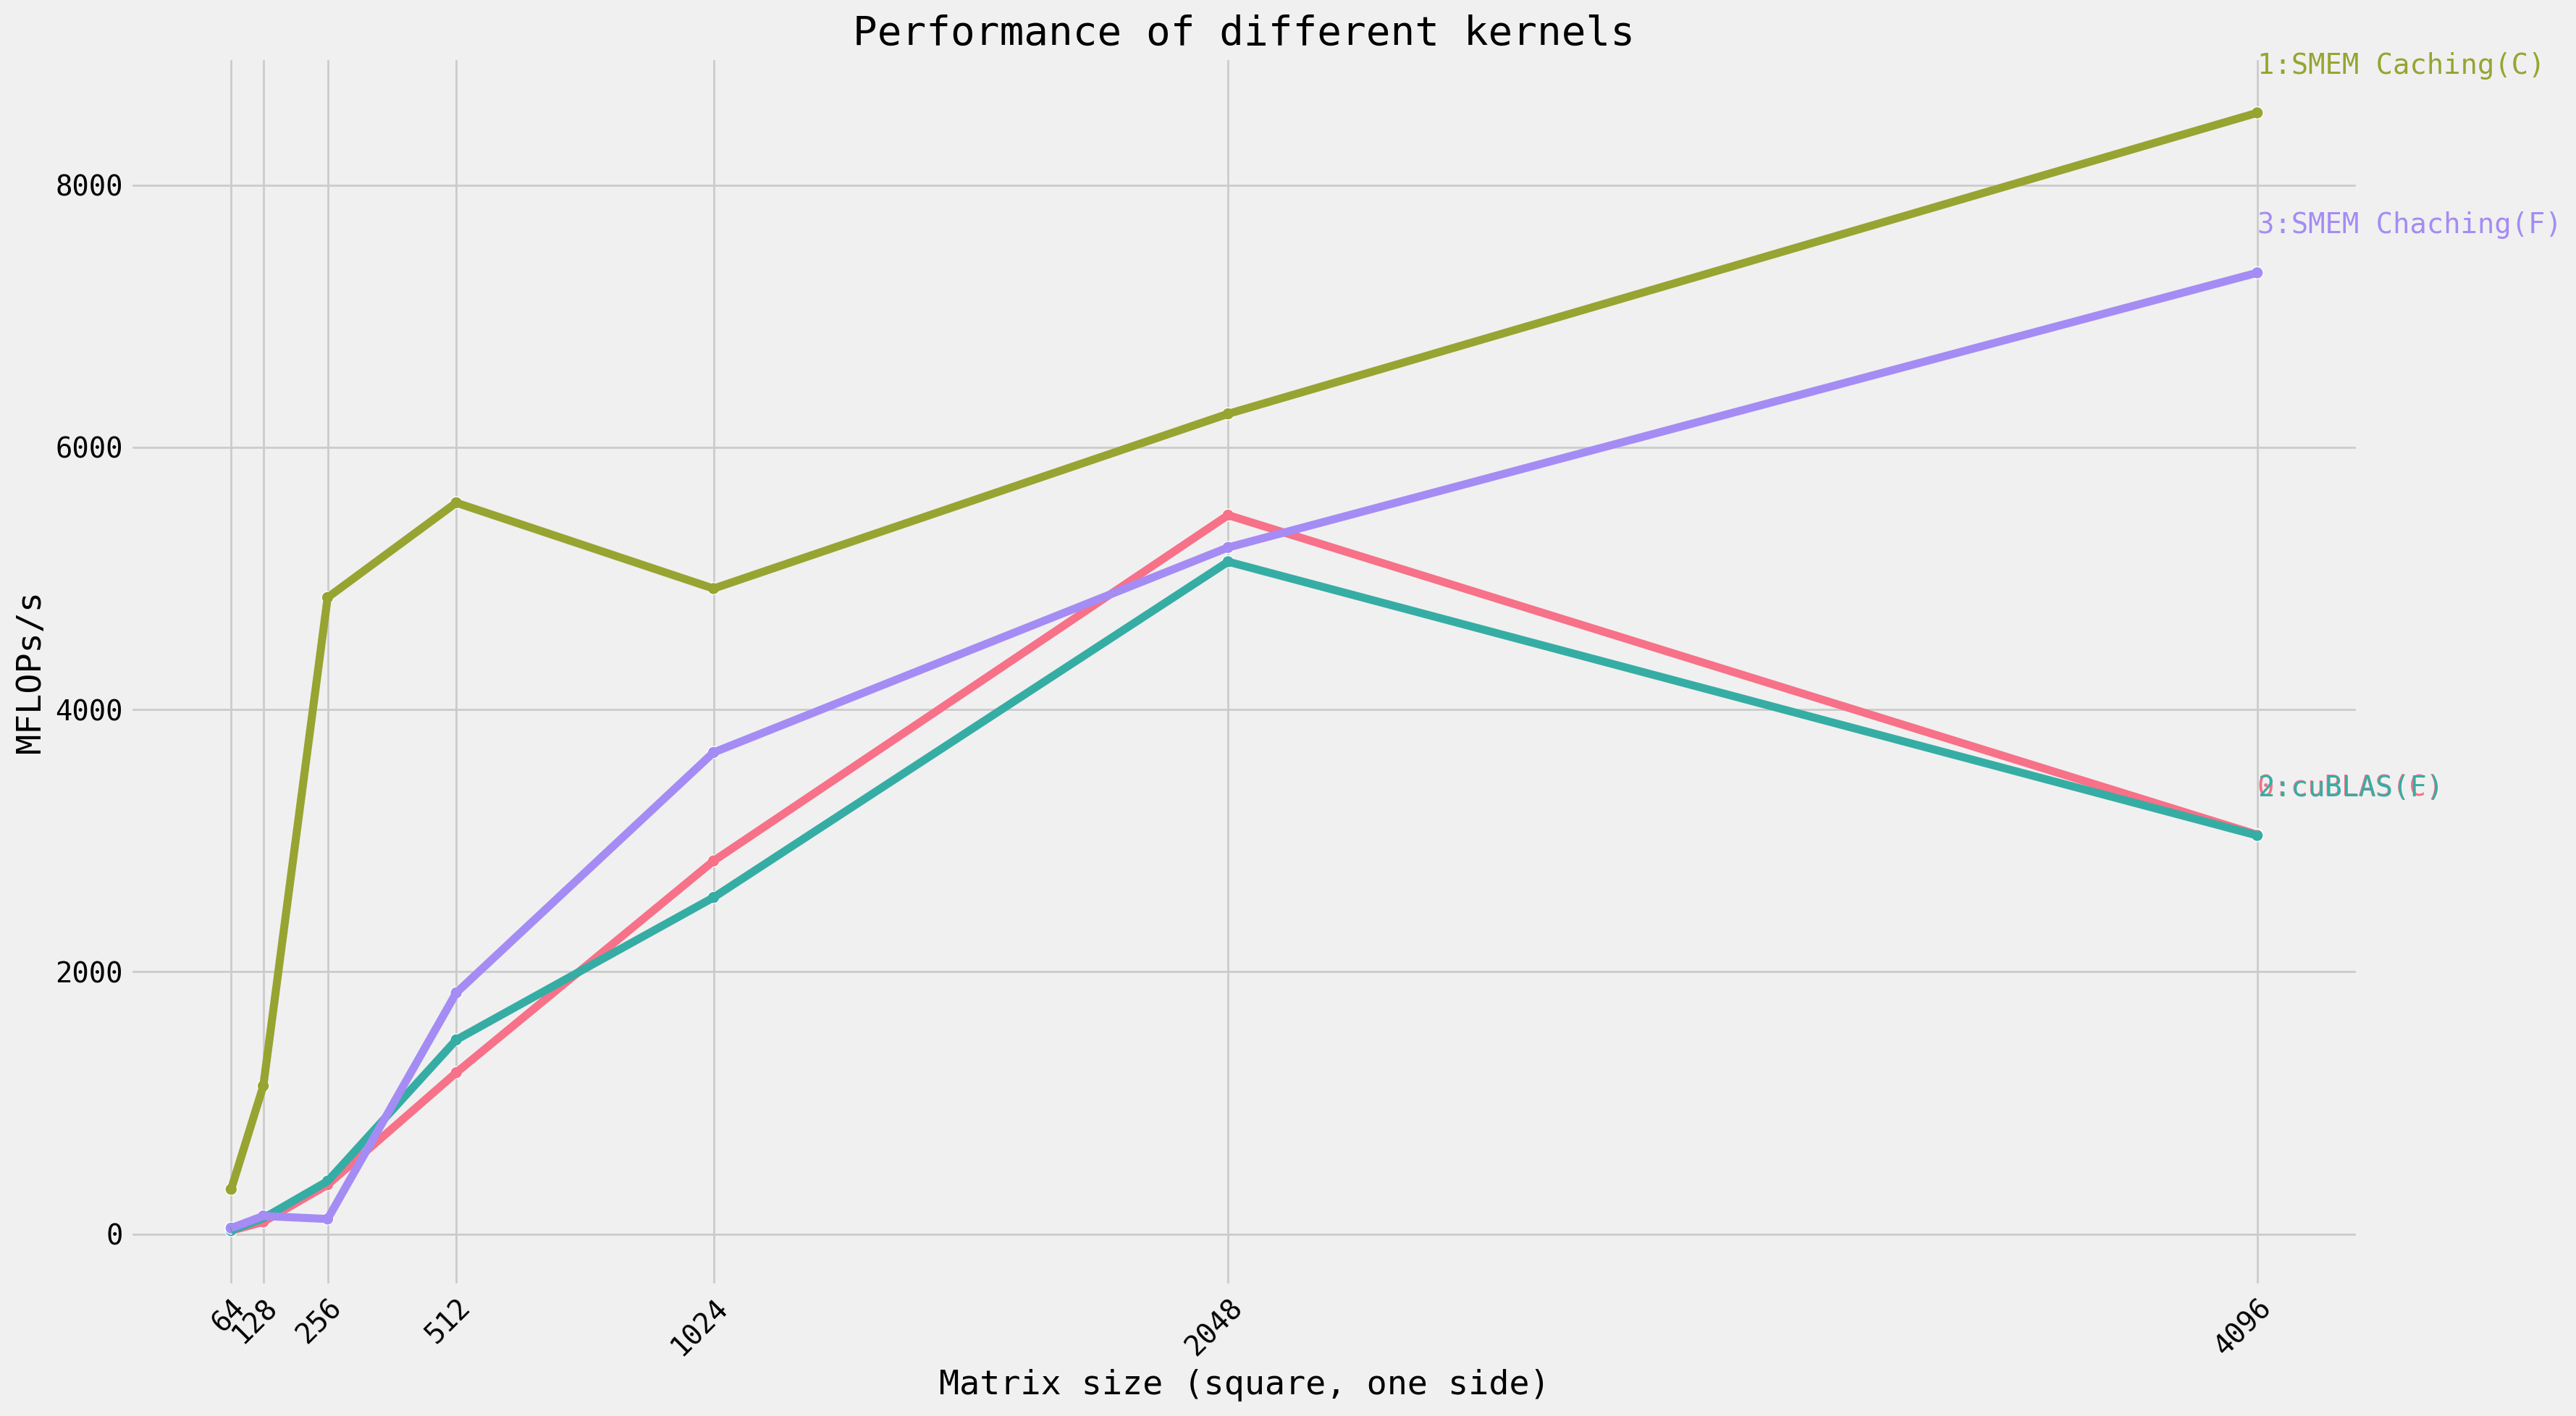

In [12]:
plot(df)

Generate relative performance DF


In [17]:
df_perform = df[df["size"] == 4096].sort_values(by="mflops", ascending=True)[["kernel", "mflops"]]
df_perform["kernel"] = df["kernel"].map({k: f"{k}: {v}" for k, v in KERNEL_NAMES.items()})
print(df_perform)
df_perform["relperf"] = df["mflops"] / df[df["kernel"] == "0: cuBLAS(C)"]["mflops"].iloc[0]
df_perform["relperf"] = df["relperf"].apply(lambda x: f"{x*100:.1f}%")
df_perform.columns = ["Kernel", "mflops/s", "Performance relative to cuBLAS"]
df_perform

                 kernel       mflops
20         2: cuBLAS(F)  3039.901431
6          0: cuBLAS(C)  3045.695924
27  3: SMEM Chaching(F)  7331.097225
13   1: SMEM Caching(C)  8551.078491


KeyError: 'relperf'

Update README

In [31]:
# # update the README.md with the new results
with open("README.md", "r") as f:
    readme = f.read()
# delete old results
readme = re.sub(
    r"<!-- sgemv_benchmark_results -->.*<!-- sgemv_benchmark_results -->",
    "<!-- sgemv_benchmark_results -->\n{}\n<!-- sgemv_benchmark_results -->".format(
        df_perform.to_markdown(index=False)
    ),
    readme,
    flags=re.DOTALL,
)
# input new results
with open("README.md", "w") as f:
    f.write(readme)


FileNotFoundError: [Errno 2] No such file or directory: 'README.md'